In [3]:
import cv2
import os
os.environ['GLOB_v'] = '0'
os.environ["GLOG_minloglevel"] = "3"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import gc
import glob
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
#from torch.cuda import empty_cache
from IPython.display import display, Image, clear_output

In [4]:
def get_video_path_list(dir_path):
    dir_list = glob.glob(dir_path)

    video_list = []

    for list in dir_list:
        file_list = []

        file_list.append(str(list).split('/')[-1])
        file_list.append(glob.glob(list + "/*"))
        video_list.append(file_list)

    return video_list

def extract_pose_landmarks(results):
    xyz_list = []

    points = [
        11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28
    ]

    neck_x = (results.pose_landmarks.landmark[11].x + results.pose_landmarks.landmark[12].x) / 2
    neck_y = (results.pose_landmarks.landmark[11].y + results.pose_landmarks.landmark[12].y) / 2
    #neck_z = (results.pose_landmarks.landmark[11].z + results.pose_landmarks.landmark[12].z) / 2

    for idx, lm in enumerate(results.pose_landmarks.landmark):
        if idx in points:
            x = int(lm.x - neck_x)
            y = int(lm.y - neck_y)
            #z = int(lm.z - neck_z)

            xyz_list.append(x)
            xyz_list.append(y)
            #xyz_list.append(z)

    return xyz_list

def video_xyz_list(xyz_list, xyz_list_list):
    xyz_list_list.append(xyz_list)

    return xyz_list_list

def generate_dataset(path):
    cap = cv2.VideoCapture(path)
    mp_pose = mp.solutions.pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

    xyz_list_list = []
    if cap.isOpened():
        while True:
            ret, frame = cap.read()
            if ret:
                image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (640, 640))
                results = mp_pose.process(image)

                if results.pose_landmarks is None: continue

                xyz_list = extract_pose_landmarks(results)

                xyz_list_list.append(xyz_list)
            else:
                break

        cap.release()

    return xyz_list_list

In [12]:
video_list = get_video_path_list("/home/shin/deeplearning-repo-1/dataset/*")
dataset = []
size = 20

cnt = 0
for classes in video_list:
    class_label = classes[0]
    if class_label == 'standing':
        label = 0
    elif class_label == 'pushup':
        label = 1
    elif class_label == 'stand_knee_raise':
        label = 2
    elif class_label == 'shoulder_press':
        label = 3
        
    for file in classes[1]:
        cnt += 1
        pose_data = generate_dataset(file)

        if cnt % 20 == 0:
            gc.collect()
            #empty_cache()

        for idx in range(0, len(pose_data), size):
            seq_list = pose_data[idx:idx+size]
            if len(seq_list) == size:
                dataset.append({'key':label,'value':seq_list})

        clear_output()

In [13]:
X, y = [], []

for data in dataset:
    y.append(data['key'])
    X.append(data['value'])

X = np.array(X)
y = np.reshape(y, (len(y), 1))

In [14]:
X.shape, y.shape

((563, 20, 24), (563, 1))

In [15]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout

In [21]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(size, 24)))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(Dense(4))

model.compile(optimizer='AdaDelta', loss='mse')
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 20, 256)        │       287,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 20, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 538,692 (2.05 MB)

 Trainable params: 538,692 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
hist = model.fit(X, y, epochs=100, batch_size=10, validation_split=0.1)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 2.5837 - val_loss: 3.9938
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6330 - val_loss: 3.9873
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.4279 - val_loss: 3.9806
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.2533 - val_loss: 3.9735
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7232 - val_loss: 3.9663
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.3853 - val_loss: 3.9587
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.3099 - val_loss: 3.9507
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.4468 - val_loss: 3.9425
Epoch 9/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7517 - val_loss: 3.9339
Epoch 10/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.4930 - val_loss: 3.9248
Epoch 11/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6386 - val_loss: 3.9154
Epoch 12/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.

In [22]:
model.save("faa.keras")

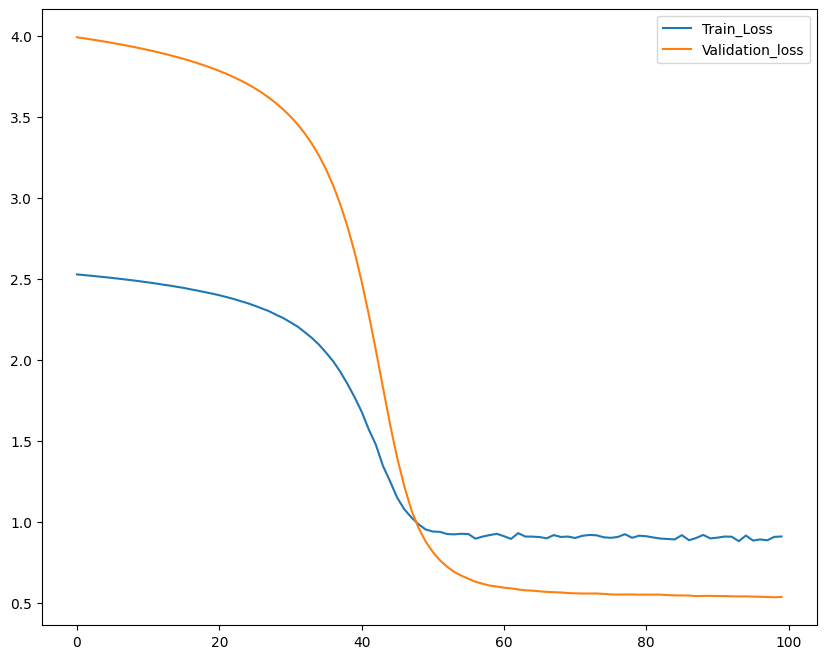

In [23]:
plt.figure(figsize=(10, 8))
plt.plot(hist.history['loss'], label='Train_Loss')
plt.plot(hist.history['val_loss'], label='Validation_loss')
plt.legend()
plt.show()

In [24]:
def video_show(frame, width=400):
    _, buffer = cv2.imencode(".jpg", frame)
    clear_output(wait=True)
    display(Image(data=buffer, width=width))

In [9]:
model = load_model('faa.keras')

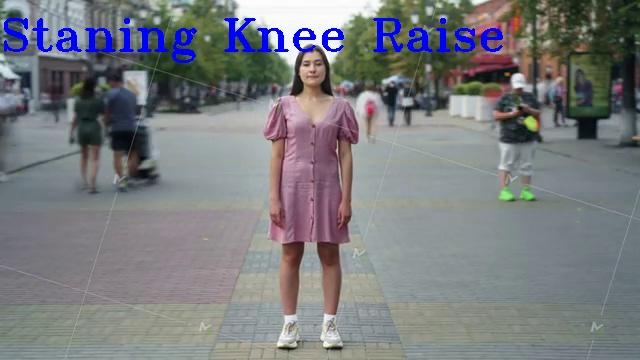

In [25]:
path = "/home/shin/deeplearning-repo-1/dataset/standing/bb.mp4"
cap = cv2.VideoCapture(path)

mp_pose = mp.solutions.pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)
sequence = []
if cap.isOpened():
    while True:
        ret, frame = cap.read()
        if ret:
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (640, 640))

            results = mp_pose.process(image)

            if results.pose_landmarks is None: continue
            
            sequence.append(extract_pose_landmarks(results))

            if len(sequence) == 10:
                data = np.array(sequence).reshape(1, 10, 24)

                predict = model.predict(data)
                predict_class = np.argmax(predict, axis=1)

                if predict_class == 0:
                    label = "Pushup"
                elif predict_class == 1:
                    label = "Standing"
                elif predict_class == 2:
                    label = "Staning Knee Raise"
                elif predict_class == 3:
                    label = "Shoulder Press"

                cv2.putText(frame, label, (0, 50), cv2.FONT_HERSHEY_TRIPLEX, 1.5, (255, 0, 0), 2)

                sequence = sequence[1:]

            video_show(frame, 640)
        else:
            break

    cap.release()
    cv2.destroyAllWindows()

In [23]:
gc.collect()

1668